In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import os
import seaborn as sns
import time
from collections import namedtuple
import matplotlib.pyplot as plt

from DeepQAgent.Agent import Agent as DQNAgent
from DeepQAgent.Agent_Priority import Agent as DQN_Prioritized_Agent
from DeepQAgent.Agent_Priority import ExpBuffer

from DeepQAgent.QNetwork import QNetwork

C:\Users\palin\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<h3>Load & instantiate the RL Environment</h3>

In [2]:
# Load the Environment
env = UnityEnvironment(file_name="./Navigation_Environment/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

action_size = brain.vector_action_space_size       # get the size of the action space
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
state_size = len(state)
score = 0                                          # initialize the score
seed = 0

<h3>Define H-params & instantiate RL Agent object</h3>

In [4]:
IS_PRIORITIZED_REPLAY = False #True

In [5]:
# total number of Episodes for Training Agent
num_episodes = 100

# Define the Agent

agent = None

if IS_PRIORITIZED_REPLAY:
    # Agent instantiation with Prioritized Experience Replay
    agent = DQN_Prioritized_Agent( state_size, action_size, seed,
                                   torch.device('cuda:0' if torch.cuda.is_available() else 'cpu:0')
                                 )
else:
    # Agent instantiation without Prioritized Experience Replay
    agent = DQNAgent( state_size, action_size, seed )

epsilon_thresh = 0.1 # 0.1
epsilon_decay = 0.99 # 0.999995 # find a decay factor so that epsilon decays each timestep to close to 0 in One episode
episodic_epsilon_decay = 0.985
epi_epsilon = 1/(episodic_epsilon_decay) # The first Episode should start from 1.0 -> we'll be decaying over Episodes too
episode_score = []

In [6]:
# define container to store the Action-heatmap
# There are 300 timesteps in each episode
# ~ define a Heatmap container which has 'Action-Space' number of rows & 'episode-timesteps' equivalent
# number of columns

action_hmap = np.zeros((action_size, 300))

action_hmap

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<h4>Load stored Agent DQN model</h4>

In [7]:
# Load from check point if any
agent.qnetwork_local.load_state_dict( torch.load('./DeepQAgent/Vanilla_Q_Agent_QLocal_Score_Thresh_13.4.pth')['state_dict'] )
agent.qnetwork_target.load_state_dict( torch.load('./DeepQAgent/Vanilla_Q_Agent_QTarget_Score_Thresh_13.4.pth')['state_dict'] )

<All keys matched successfully>

<h3>Run Inference on the Environment for the Loaded Agent Model</h3>

In [8]:
start_time = time.time()

try: 
    for i in range(num_episodes):
        """
            At the beginning of the Episode ->
                1> Initialise the episode_score = 0
                2> Reset the Environment State
        """
        score = 0                                         # Initialise Agent's episode score
        inspect_score = 0                                 # Initilaise Avg Score over 'inpect_episodes'
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]           # get the curent state
        
        # epsilon = 1.0 at first Episode -> decay episodic epsilon over episodes
        epi_epsilon = epi_epsilon*episodic_epsilon_decay  
        epi_epsilon = 0.0 if epi_epsilon < epsilon_thresh else epi_epsilon # threshold to stop Agent action Exploration
        
        epsilon = epi_epsilon # init epsilon for one Episode which wil decay over timesteps in an Episode
        
        done = False
        episode_start_time = time.time()
        timestep = 1
        yellow, blue = 0, 0

        # Keep running the environment simulation until the Terminal State has been reached
        # EPISODE RUN
        while not done:
            
            action, q_estimate = None, None
            
            if IS_PRIORITIZED_REPLAY:
                # Agent WITH Prioritized Action Replay
                action, q_estimate = agent.act(state, epsilon) # Agent Action
            else:
                # Agent without any Prioritized Action Replay
                action = agent.act(state, epsilon) # action = agent.act(state)
            
            action = action.astype('int32')
            
            # Update the Action Heatmap for the specific timestep in the Episode
            action_hmap[action][timestep-1] += 1
            
            env_info = env.step(action)[brain_name] # send Agent action to the Environment

            # Obtain:> 'next_state', 'reward', 'done' params for the Agent-Environment interaction
            next_state = env_info.vector_observations[0]   
            reward = env_info.rewards[0]                   
            done = env_info.local_done[0]     
            
            # Update the timestep-score
            score += reward

            # State-transition: update current state to next state
            state = next_state

            # Epsion (Greedy parameter) decay over timesteps & capping to low_thresh of 0.1
            epsilon = epsilon * epsilon_decay
            epsilon = 0.0001 if epsilon < epsilon_thresh else epsilon  

            timestep += 1

        # One EPISODE RUN has completed
        episode_score.append(score)

        log="Episode: {} ~ Tstep: {}| Score: {}".format( i+1, timestep, score )
        
        log = log + " "*(100 - len(log))
        print( log, end = "\r" );# print(log)
        
except KeyboardInterrupt:
    print("\nKeyboardInterrupt exception -> Aborting RL Agent Train")
    
end_time = time.time()
simul_time = np.round(end_time-start_time, 3)

print("\nTotal Elapsed Simulation time: {} seconds | {} minutes".format( simul_time, np.round(simul_time/60.0, 2) )
     )

# Close the Environment
env.close()

Episode: 100 ~ Tstep: 301| Score: 8.0                                                               
Total Elapsed Simulation time: 149.365 seconds | 2.49 minutes


<h4>Get Heatmap for Agent Reward observed during Inference</h4>

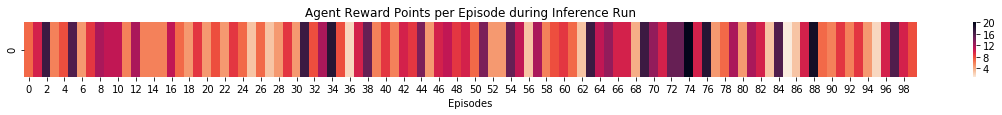

In [31]:
%matplotlib inline

plt.figure(figsize=(20, 1))
sns.heatmap(np.reshape(episode_score, (1, len(episode_score))), cmap="rocket_r")

plt.xlabel("Episodes")
plt.title("Agent Reward Points per Episode during Inference Run")

plt.show()

<h4>Get Heatmap for Agent Action-Space Decisions per timestep in Episode observed during Inference</h4>

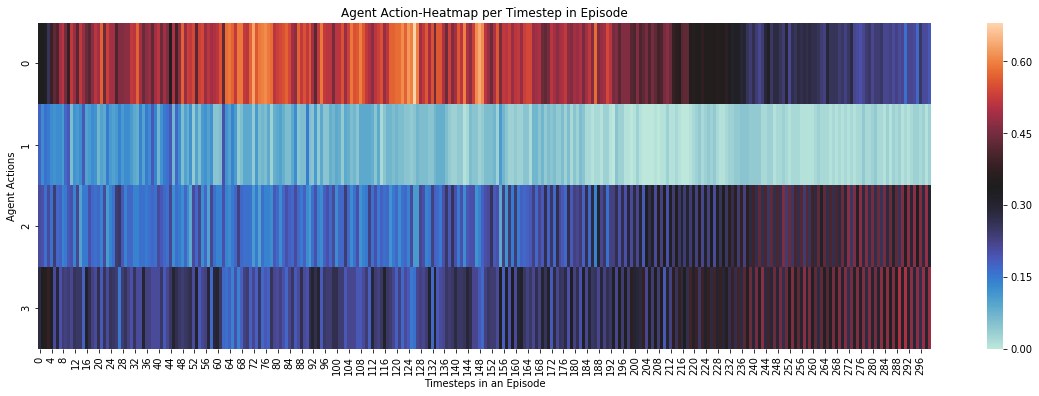

In [43]:
%matplotlib inline

plt.figure(figsize=(20, 6))
sns.heatmap(action_hmap/num_episodes, cmap="icefire")

plt.xlabel("Timesteps in an Episode")
plt.ylabel("Agent Actions")
plt.title("Agent Action-Heatmap per Timestep in Episode")

plt.show()